# Diagnostics of nested loops

 - Elwin van 't Wout
 - Pontificia Universidad Católica de Chile
 - IMT3870
 - 26-8-2024

This tutorial shows how to get diagnostics of the optimisations Numba performs.

In [2]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
from numba import njit, prange

Let us use two sample images.

In [3]:
dataset = datasets.load_sample_images()
china_int, flower_int = dataset.images

In [11]:
china_float = np.array(china_int, dtype=np.float64) / 255
flower_float = np.array(flower_int, dtype=np.float64) / 255

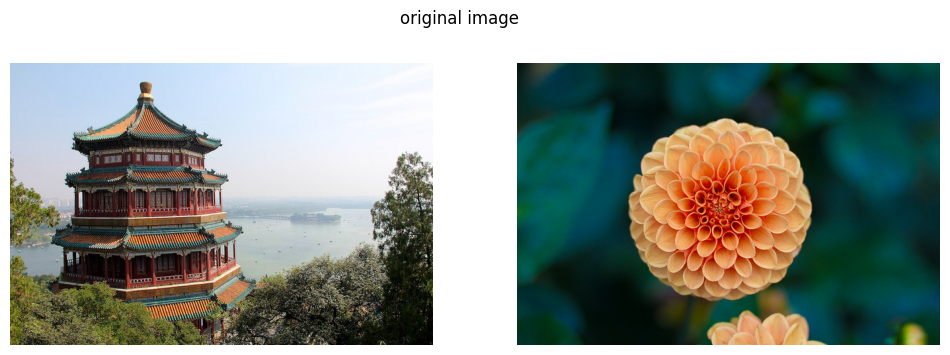

In [12]:
fig, axs = plt.subplots(1,2, figsize=(12,4))

im0 = axs[0].imshow(china_float)
im1 = axs[1].imshow(flower_float)

fig.suptitle('original image')

axs[0].axis('off')
axs[1].axis('off')

plt.show()

In [6]:
print(china_float.shape)
print(flower_float.shape)

(427, 640, 3)
(427, 640, 3)


In [7]:
@njit(parallel=True)
def invert_colour(my_image):
    output_size = (425, 638, 3)
    output_image = np.zeros(output_size)
    for i in prange(output_size[0]):
        for j in prange(output_size[1]):
            for k in prange(3):
                output_image[i,j,k] = 1 - my_image[i,j,k]
    return output_image

We like to invert the colours of the figures. For this, we need to calculate the inverse colour for each pixel and each channel. These are independent instructions which can be parallelised with Numba.

In [8]:
china_inverted = invert_colour(china_float)
flower_inverted = invert_colour(flower_float)

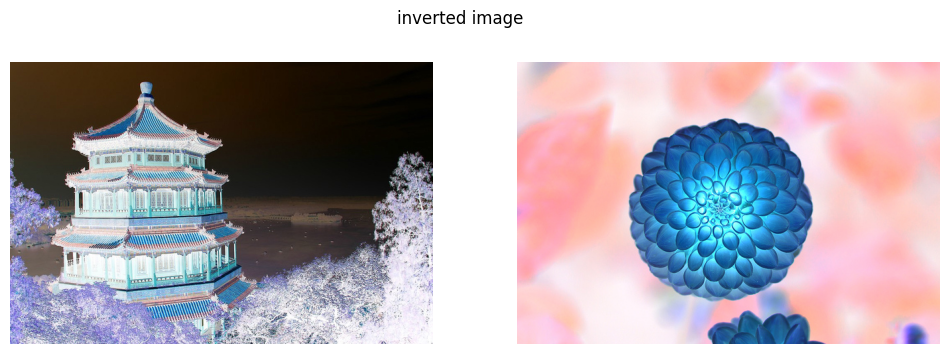

In [9]:
fig, axs = plt.subplots(1,2, figsize=(12,4))

im0 = axs[0].imshow(china_inverted)
im1 = axs[1].imshow(flower_inverted)

fig.suptitle('inverted image')

axs[0].axis('off')
axs[1].axis('off')

plt.show()

Indeed, the figures look different after the inversion of the colours.

In [10]:
invert_colour.parallel_diagnostics()

 
 Parallel Accelerator Optimizing:  Function invert_colour, 
C:\Users\alber\AppData\Local\Temp\ipykernel_13604\2198814884.py (1)  


Parallel loop listing for  Function invert_colour, C:\Users\alber\AppData\Local\Temp\ipykernel_13604\2198814884.py (1) 
-------------------------------------------------------------|loop #ID
@njit(parallel=True)                                         | 
def invert_colour(my_image):                                 | 
    output_size = (425, 638, 3)                              | 
    output_image = np.zeros(output_size)---------------------| #0
    for i in prange(output_size[0]):-------------------------| #3
        for j in prange(output_size[1]):---------------------| #2
            for k in prange(3):------------------------------| #1
                output_image[i,j,k] = 1 - my_image[i,j,k]    | 
    return output_image                                      | 
------------------------------ After Optimisation ------------------------------
Parallel r

The diagnostics report shows something interesting. We requested Numba to parallelise three nested loops. However, Numba only parallelises the outermost loop and runs the inner two in sequence. This is to avoid performance deterioration due to over-subscription of threads.